#Automatic Brain Tumor Detection and Semantic Segmentation Using U-Net Loss Jacard Metric Iou
Mohammad Reza Tabrizi

#Importar dados
##A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [98]:
from google.colab import files
uploaded = files.upload()

Saving lgg-mri-segmentation.zip to lgg-mri-segmentation (2).zip


In [99]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['lgg-mri-segmentation.zip']), 'r')
data.extractall()

In [100]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importar dados
### A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [101]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [102]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_21.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_1.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_31.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_18.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_15.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_4.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_199802

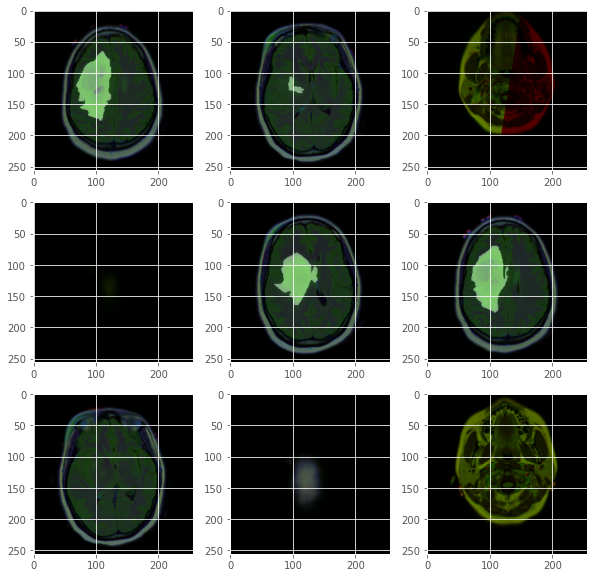

In [103]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [104]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})

In [105]:
df.head()

,filename,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [106]:
X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [107]:

for i in tqdm(range (len(df))):
    img_path=train_files[i]
    img=cv2.imread(img_path)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    msk_path=mask_files[i]
    mask_ =cv2.imread(msk_path)
    mask_ = rgb2gray(mask_)
    mask_.shape
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                              preserve_range=True), axis=-1)
    Y_train[i] = mask_

100%|██████████| 3929/3929 [00:44<00:00, 87.66it/s]


In [108]:
print(X_train.shape)
print(Y_train.shape)

(3929, 128, 128, 3)
(3929, 128, 128, 1)


In [109]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print(X_train1.shape)
print(X_test1.shape)

(3536, 128, 128, 3)
(393, 128, 128, 3)


# Sanety check, View few Images

<function matplotlib.pyplot.show>

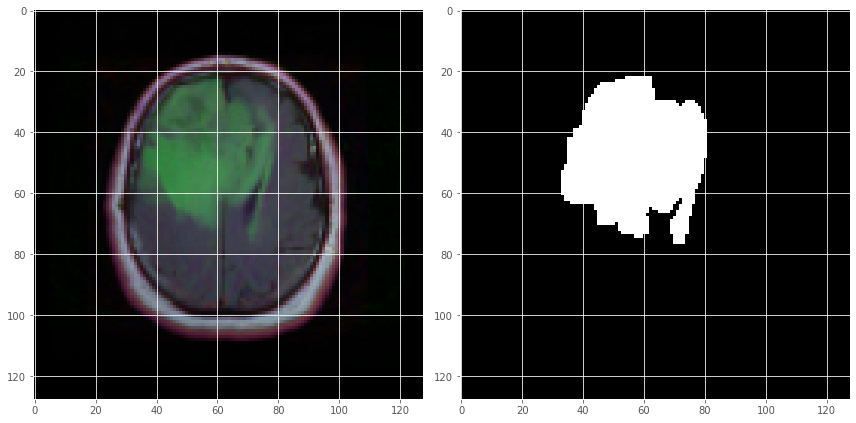

In [110]:
image_number = random.randint(0,len(X_train1))
plt.figure(figsize=(12,6))
plt.subplot(121)
imshow(X_train1[image_number])
plt.subplot(122)
imshow(np.squeeze(y_train1[image_number]))
plt.show

#As funções seguintes apresentam  configurações de redes neuronais UNet, a testar nas secções seguintes:

##Função de Jacard

In [111]:
smooth=0.000001
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    intersection=K.sum(y_truef* y_predf)
    return((2.* intersection + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))
def dice_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 -dice_coef(y_true, y_pred)


In [112]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [113]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return 1 -dice_coef(y_true, y_pred)

In [114]:
def dice_coef(y_true, y_pred, smooth=0.01):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return 1 -dice_coef(y_true, y_pred)

In [115]:
smooth=0.0001
#smooth=1.
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [116]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dropout
from keras.layers.merge import concatenate
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model
import pydot
import graphviz

def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv2D(nb_features, kernel_size=(1, 1), padding='same', kernel_initializer='he_uniform',
               data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    t = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_last')(t)
    return t

def Tiramisu(layer_per_block, n_pool=5, growth_rate=16):
    input_layer = Input(shape=(128, 128, 3))
    t = Conv2D(48, kernel_size=(3, 3), strides=(1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv2DTranspose(keep_nb_features, strides=2, kernel_size=(3, 3), padding='same',
                            data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('sigmoid')(t)
    return Model(inputs=input_layer, outputs=output_layer)


layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]



In [117]:
tiramisu_Loss_Jacard_Metric_Iou_l = Tiramisu(layer_per_block)


In [118]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-07)

In [119]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.models import Model
from keras import regularizers
import tensorflow as tf
#from keras.backend import tensorflow_backend

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D

from keras import backend as K

from keras import callbacks
import math
import keras.models as models
#from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization

from keras.layers import Conv2D, Conv2DTranspose

In [120]:
tiramisu_Loss_Jacard_Metric_Iou_l.summary()
tf.keras.utils.plot_model(tiramisu_Loss_Jacard_Metric_Iou_l, "tiramisu_Loss_Jacard_Metric_Iou_l.png", show_shapes = True)
tiramisu_Loss_Jacard_Metric_Iou_l.compile(optimizer=opt,loss = [dice_coef_loss], metrics=[iou])

#loss = 1-iou
#loss='binary_crossentropy'

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_367 (Conv2D)             (None, 128, 128, 48) 1344        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 128, 128, 48) 512         conv2d_367[0][0]                 
__________________________________________________________________________________________________
activation_194 (Activation)     (None, 128, 128, 48) 0           batch_normalization_192[0][0]    
___________________________________________________________________________________________

In [121]:
nb_epoch = 100
batch_size = 16

In [122]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('tiramisu_Loss_Jacard_Metric_Iou_l.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
history_tiramisu_Loss_Jacard_Metric_Iou_l = tiramisu_Loss_Jacard_Metric_Iou_l.fit(X_train1, y_train1,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    callbacks=callbacks,
                    verbose= 1,
                    validation_data= (X_test1,y_test1),
                    shuffle=False)

Epoch 1/100
221/221 [==============================] - 109s 421ms/step - loss: 0.1228 - iou: 0.1090 - val_loss: -0.2741 - val_iou: 0.3976
Epoch 2/100
221/221 [==============================] - 87s 394ms/step - loss: -0.3190 - iou: 0.4507 - val_loss: -0.3315 - val_iou: 0.4482
Epoch 3/100
221/221 [==============================] - 87s 395ms/step - loss: -0.3687 - iou: 0.4970 - val_loss: -0.4098 - val_iou: 0.5227
Epoch 4/100
221/221 [==============================] - 87s 395ms/step - loss: -0.4068 - iou: 0.5307 - val_loss: -0.4267 - val_iou: 0.5361
Epoch 5/100
221/221 [==============================] - 87s 394ms/step - loss: -0.4514 - iou: 0.5749 - val_loss: -0.4111 - val_iou: 0.5159
Epoch 6/100
221/221 [==============================] - 87s 394ms/step - loss: -0.4720 - iou: 0.5913 - val_loss: -0.4742 - val_iou: 0.5801
Epoch 7/100
221/221 [==============================] - 87s 395ms/step - loss: -0.4947 - iou: 0.6125 - val_loss: -0.4926 - val_iou: 0.5961
Epoch 8/100
221/221 [=============

In [123]:
y_pred = tiramisu_Loss_Jacard_Metric_Iou_l.predict(X_test1,verbose=0)
y_pred_trasholded = y_pred > 0.5

intersection = np.logical_and(y_test1, y_pred_trasholded)
union = np.logical_or(y_test1,y_pred_trasholded)
iou_score = np.sum(intersection)/ np.sum(union)
print ("IoU score is: ",iou_score)

IoU score is:  0.8152861515629348


In [124]:
history_tiramisu_Loss_Jacard_Metric_Iou_l.history.keys()

dict_keys(['loss', 'iou', 'val_loss', 'val_iou'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


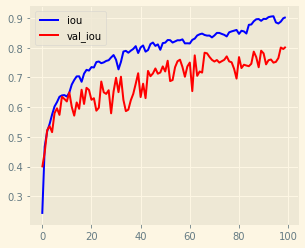

In [125]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_tiramisu_Loss_Jacard_Metric_Iou_l.history['iou']),label='iou', linestyle='-', color='b')
  plt.plot((history_tiramisu_Loss_Jacard_Metric_Iou_l.history['val_iou']),label='val_iou', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


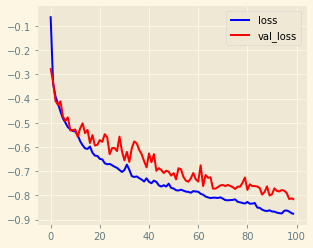

In [126]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_tiramisu_Loss_Jacard_Metric_Iou_l.history['loss']),label='loss', linestyle='-', color='b')
  plt.plot((history_tiramisu_Loss_Jacard_Metric_Iou_l.history['val_loss']),label='val_loss', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show>

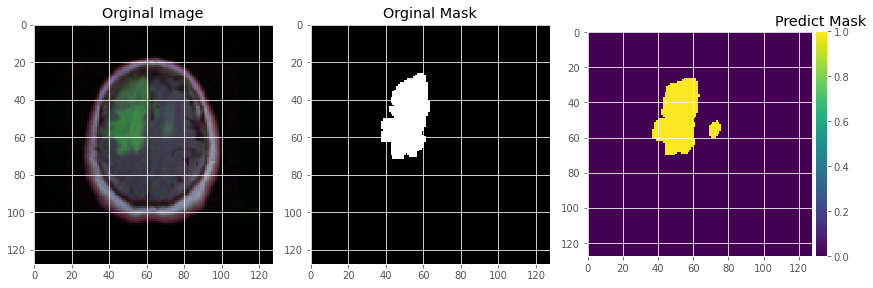

In [137]:
preds_test_t = (y_pred > 0.5).astype(np.uint8)
# Perform a sanity check on some random trai ning samples
ix = random.randint(0, len(preds_test_t))
plt.figure(figsize=(12,6))
plt.subplot(131)
imshow(X_test1[ix])
plt.title('Orginal Image')
plt.subplot(132)
imshow(np.squeeze(y_test1[ix]))
plt.title('Orginal Mask')
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix]))
plt.title('Predict Mask')
plt.show



